# Chapter 12  Control III – model-predictive & non-linear
## 12.1 Introduction

Model Predictive Control (MPC) builds on the optimal control concepts from previous chapters (e.g., LQR in Chapter 11) by incorporating predictions, optimization, and constraints in real-time. This chapter provides a concise overview, focusing on core definitions, descriptions, and simple code examples. We'll connect MPC to reinforcement learning (RL) in Chapter 13, where MPC-like planning inspires model-based RL methods.




## 12.2 MPC Definition and Description

MPC is a feedback control strategy that:

- Uses a dynamic model to predict the system's future states over a finite prediction horizon (e.g., $  N  $ steps).
- Solves an optimization problem at each time step to find the optimal sequence of control inputs that minimizes a cost function (e.g., quadratic error to a setpoint) while respecting constraints (e.g., input limits, state bounds).
- Applies only the first control input from the sequence.
- Repeats the process at the next time step with updated measurements (receding horizon).

Key advantages:

- Handles multi-input multi-output (MIMO) systems, constraints, and non-linearities explicitly.
- Bridges classical control (e.g., PID, LQR) with optimization-based methods.


For a discrete-time system $  \mathbf{y}_{k+1} = \mathbf{A} \mathbf{y}_k + \mathbf{B} \mathbf{u}_k  $, the MPC optimization problem is typically:

$$\min_{\mathbf{u}_{k:k+N-1}} \sum_{i=1}^{N} (\mathbf{y}_{k+i} - \mathbf{y}_{\text{ref}})^T \mathbf{Q} (\mathbf{y}_{k+i} - \mathbf{y}_{\text{ref}}) + \mathbf{u}_{k+i-1}^T \mathbf{R} \mathbf{u}_{k+i-1}$$

Subject to dynamics, $  \mathbf{y}_{k+i} = \mathbf{A} \mathbf{y}_{k+i-1} + \mathbf{B} \mathbf{u}_{k+i-1}  $, and constraints (e.g., $  |\mathbf{u}| \leq \mathbf{u}_{\max}  $).


> ### 12.3 Linear MPC Example
>
> We'll simulate a simple double-integrator system (e.g., position control): $  \dot{\mathbf{y}} = \begin{bmatrix} 0 & 1 \\ 0 & 0 \end{bmatrix} \mathbf{y} + \begin{bmatrix} 0 \\ 1 \end{bmatrix} u  $, discretized with time step $  \Delta t = 0.1  $.
>
> Use scipy.optimize.minimize for the quadratic cost (approximates QP for linear cases).

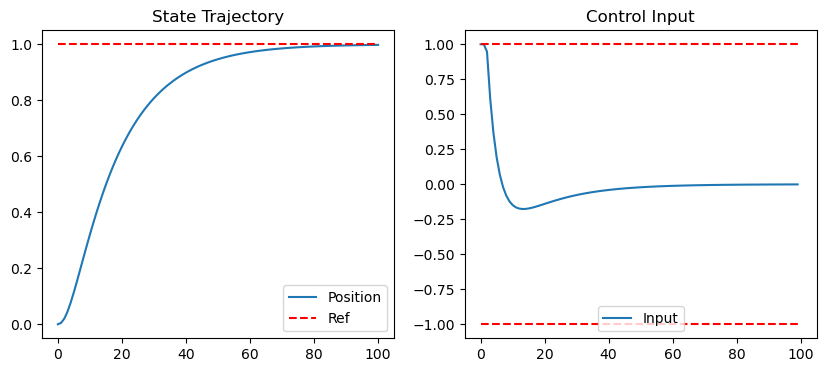

In [12]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# System matrices (discretized double integrator)
dt = 0.1
A = np.array([[1, dt], [0, 1]])
B = np.array([[0.5*dt**2], [dt]])
n_states = 2
n_inputs = 1

# MPC parameters
N = 10  # Prediction horizon
Q = np.eye(n_states)  # State cost
R = 0.1 * np.eye(n_inputs)  # Input cost
y_ref = np.array([1.0, 0.0])  # Setpoint: position=1, velocity=0
u_min, u_max = -1.0, 1.0  # Input constraints

def mpc_cost(u_seq, y0):
    """Quadratic cost function for optimization."""
    cost = 0.0
    y = y0.reshape(-1, 1)  # Ensure column vector
    for i in range(N):
        u = u_seq[i*n_inputs:(i+1)*n_inputs].reshape(-1, 1)
        y = A @ y + B @ u
        state_err = y - y_ref.reshape(-1, 1)
        cost += (state_err.T @ Q @ state_err).item() + (u.T @ R @ u).item()
    return cost

# Simulation
T = 100  # Time steps
y_traj = np.zeros((n_states, T+1))
u_traj = np.zeros((n_inputs, T))
y = np.array([0.0, 0.0])  # Initial state
y_traj[:, 0] = y

for t in range(T):
    # Optimize: initial guess (warm-start: shift previous solution or zeros)
    u_guess = np.zeros(N * n_inputs)
    bounds = [(u_min, u_max)] * (N * n_inputs)
    res = minimize(mpc_cost, u_guess, args=(y,), bounds=bounds)
    u_seq_opt = res.x
    u = u_seq_opt[:n_inputs]  # Apply first input
    y = (A @ y.reshape(-1, 1) + B @ u.reshape(-1, 1)).flatten()
    y_traj[:, t+1] = y
    u_traj[:, t] = u

# Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(y_traj[0], label='Position')
plt.plot([0, T], [y_ref[0], y_ref[0]], 'r--', label='Ref')
plt.legend(); plt.title('State Trajectory')
plt.subplot(1, 2, 2)
plt.plot(u_traj[0], label='Input')
plt.plot([0, T], [u_max, u_max], 'r--'); plt.plot([0, T], [u_min, u_min], 'r--')
plt.legend(); plt.title('Control Input')
plt.show()

This code solves the MPC problem at each step, applying constraints via bounds. Warm-starting can be added by shifting u_seq_opt from the previous step as u_guess (e.g., u_guess = np.concatenate((u_seq_opt[n_inputs:], np.zeros(n_inputs)))).

## 12.4 Nonlinear MPC and Successive Linearization

For nonlinear systems (e.g., $  \mathbf{y}_{k+1} = \mathbf{f}(\mathbf{y}_k, \mathbf{u}_k)  $), the optimization becomes non-convex. Use scipy.optimize.minimize with methods like 'SLSQP' for constraints.
- Successive linearization: At each MPC step, linearize the nonlinear model around the current state/trajectory, solve the linear MPC, and iterate (e.g., 2-5 times) for refinement.
- Warm-start: Use the previous optimal sequence as the initial guess to speed up convergence.
- Constraint handling: Include state/input constraints directly in the optimizer (e.g., via constraints arg in minimize).

 > ### Example: nonlinear MPC
> Consider the nonlinear pendulum: $  \frac{d^2 \theta}{dt^2} = -\frac{g}{l} \sin(\theta) + \frac{1}{ml^2} u  $):

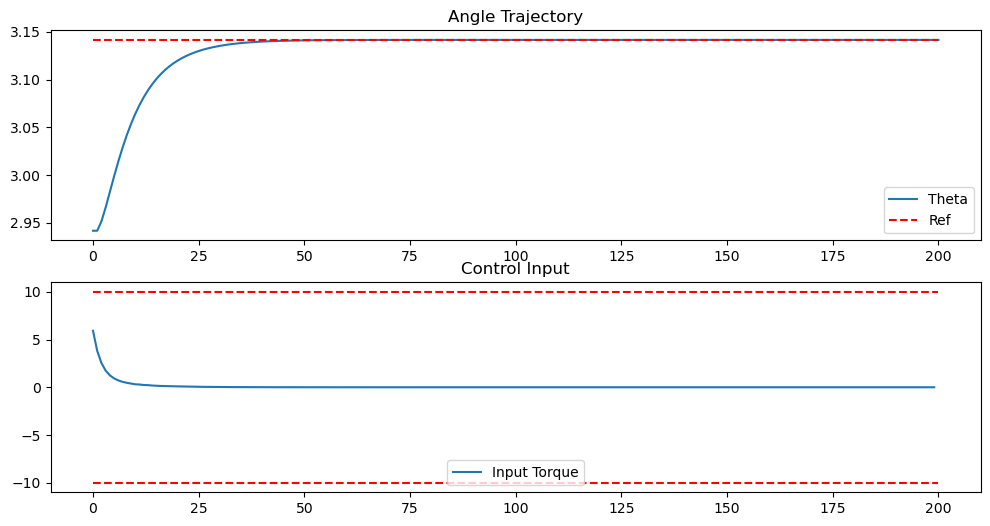

In [8]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Nonlinear pendulum parameters
g, l, m = 9.81, 1.0, 1.0
dt = 0.05
y_ref = np.array([np.pi, 0.0])  # Inverted position, zero velocity
N = 10  # Prediction horizon
Q = np.diag([10.0, 1.0])  # State weights: more on angle
R = 0.01  # Input weight (small to allow larger torques)
u_min, u_max = -10.0, 10.0  # Input constraints

def nonlinear_dynamics(y, u):
    theta, omega = y
    dtheta_dt = omega
    d2theta_dt2 = - (g/l) * np.sin(theta) + (1/(m*l**2)) * u
    return np.array([theta + dt * dtheta_dt, omega + dt * d2theta_dt2])

def nl_mpc_cost(u_seq, y0):
    cost = 0.0
    y = y0.copy()
    for i in range(N):
        u = u_seq[i]
        y = nonlinear_dynamics(y, u)
        cost += (y - y_ref) @ Q @ (y - y_ref) + R * u**2
    return cost

# Simulation
T = 200  # Time steps (longer for stabilization)
y_traj = np.zeros((2, T+1))
u_traj = np.zeros(T)
y = np.array([np.pi - 0.2, 0.0])  # Initial state: slightly off inverted
y_traj[:, 0] = y
prev_u_seq = np.zeros(N)  # For warm-start

for t in range(T):
    u_guess = prev_u_seq
    bounds = [(u_min, u_max)] * N
    res = minimize(nl_mpc_cost, u_guess, args=(y,), method='SLSQP', bounds=bounds)
    u_seq_opt = res.x
    u = u_seq_opt[0]
    y = nonlinear_dynamics(y, u)
    y_traj[:, t+1] = y
    u_traj[t] = u
    # Warm-start: shift sequence and append zero
    prev_u_seq = np.concatenate((u_seq_opt[1:], [0.0]))

# Plot
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(y_traj[0], label='Theta')
plt.plot([0, T], [y_ref[0], y_ref[0]], 'r--', label='Ref')
plt.legend(); plt.title('Angle Trajectory')
plt.subplot(2, 1, 2)
plt.plot(u_traj, label='Input Torque')
plt.plot([0, T], [u_max, u_max], 'r--'); plt.plot([0, T], [u_min, u_min], 'r--')
plt.legend(); plt.title('Control Input')
plt.show()

(Optional) For Jacobians, use sympy to compute linearizations symbolically:

In [7]:
import sympy as sp

theta, omega, u = sp.symbols('theta omega u')
f = sp.Matrix([omega, - (g/l) * sp.sin(theta) + (1/(m*l**2)) * u])
A_sym = f.jacobian([theta, omega])
B_sym = f.jacobian([u])
# Lambdify for numerical eval: A = sp.lambdify((theta, omega, u), A_sym)

## 12.5 (Optional) Intro to Data-Driven MPC: SINDy / DMDc
For systems without known models, use data-driven methods:

SINDy (Sparse Identification of Nonlinear Dynamics): Fits sparse nonlinear ODEs from data via regression.
DMDc (Dynamic Mode Decomposition with Control): Extends DMD for controlled systems, estimating A/B matrices.

Use these to learn models for MPC (e.g., via scipy regression). Skip for now; see literature for integration with MPC.



## 12.6 Connection to Reinforcement Learning (Chapter 13)

MPC is a form of model-based optimal control with finite horizons and explicit models/constraints. RL (Chapter 13) extends this to:

Infinite horizons via value/policy functions.
Learning models/rewards from data (model-free vs. model-based RL, where MPC inspires planning in model-based RL like Dyna or AlphaZero).
Handling uncertainty (e.g., stochastic MDPs) with safety (similar to MPC constraints via reward shaping).

In Chapter 14's orbit station-keeping, RL agents can be viewed as "learning MPC" policies for complex, nonlinear dynamics.
For further reading: "Model Predictive Control" by Rawlings et al.; connect to RL via "Reinforcement Learning: An Introduction" by Sutton & Barto.